# Sparsistent model discovery
## KdV equation

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.3'

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
from time import time

from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge

import jax
from jax import random, numpy as jnp
from flax import optim
from flax.core import freeze, unfreeze

import sys
sys.path.append('pdeX')
from sparsity_estimators import ir_cond,ir_condAL, get_mask_single
from DeepModx import pdeX, create_update_state, loss_fn_pinn_multi2, mse_test,mask_scheduler, Logger, Convergence

# General params

In [2]:
key = random.PRNGKey(42)
np.random.seed(42)

In [3]:
# Data
noise_level = 0.15
number_of_samples = 2000
path = 'logs/xKdV15' # path to log tensorboard files

x     = np.load('data/kdv_x.npy')
t     = np.load('data/kdv_t.npy')
u     = np.array(np.load('data/kdv_u.npy'),dtype=np.float32).reshape(len(x),len(t))


# DeepMod parameters
# neural net architecture
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]

# learning parameters
deltaSP = 1e-5 # target MSE on test set before triggering sparsity for the first time
deltaC = 1e-2  # converge criterion
learning_rate = 5e-5
max_epochs = 1e5+1

# logging
write_tensorboard = True

# sparsity method
method = 'adaLassoSS'

In [4]:
# library terms labels

lib_labels = ['1',
r'$u_x$',
r'$u_{xx}$',
r'$u_{xxx}$',
r'$u_{xxxx}$',
r'$u_{xxxxx}$',
r'$u$',
r'$uu_x$',
r'$uu_{xx}$',
r'$uu_{xxx}$',
r'$uu_{xxxx}$',
r'$uu_{xxxxx}$',
r'$u^2$',
r'$u^2u_x$',
r'$u^2u_{xx}$',
r'$u^2u_{xxx}$',
r'$u^2u_{xxxx}$',
r'$u^2u_{xxxxx}$',
r'$u^3$',
r'$u^3u_x$',
r'$u^3u_{xx}$',
r'$u^3u_{xxx}$',
r'$u^3u_{xxxx}$',
r'$u^3u_{xxxxx}$',
r'$u^4$',
r'$u^4u_x$',
r'$u^4u_{xx}$',
r'$u^4u_{xxx}$',
r'$u^4u_{xxxx}$',
r'$u^4u_{xxxxx}$',
r'$u^5$',
r'$u^5u_x$',
r'$u^5u_{xx}$',
r'$u^5u_{xxx}$',
r'$u^5u_{xxxx}$',
r'$u^5u_{xxxxx}$']

# Input data with some noise

In [5]:
noise_l = noise_level*np.std(u)*np.random.randn(u.shape[0],u.shape[1])
u = u + noise_l

In [6]:
x_grid,  t_grid = jnp.meshgrid(x,  t, indexing="ij")

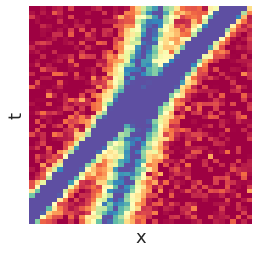

In [7]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

u1_noisy = u

bx = sns.heatmap(u1_noisy.T,ax=ax,vmin=0,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');

## subsampling and normalizing

In [8]:
idx = resample(np.arange(u1_noisy.ravel().shape[0]),replace=False,random_state=0,n_samples=number_of_samples)

u1_noisy_shuffled = (u1_noisy.ravel())[idx]
xs = ((x_grid.ravel())[idx]).reshape(-1,1)
ts = ((t_grid).ravel()[idx]).reshape(-1,1)

In [9]:
scale_from_outputs = []
u_d = []

# scaling and subsampling
u_sampled = u1_noisy_shuffled.reshape(-1,1)
u_max = u_sampled.max()
scale_from_outputs.append(u_max)
u_d.append(u_sampled/u_max)    

In [10]:
X_data = jnp.concatenate([ts/t.max(),xs/x.max()],axis=1)
y_data = jnp.concatenate(u_d,axis=0)

In [11]:
print(X_data.shape)
print(y_data.shape)

(2000, 2)
(2000, 1)


## splitting into training and testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

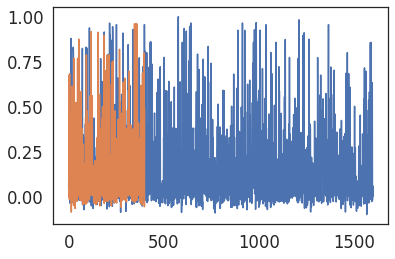

In [13]:
plt.plot(y_train[:,0])
plt.plot(y_test[:,0])

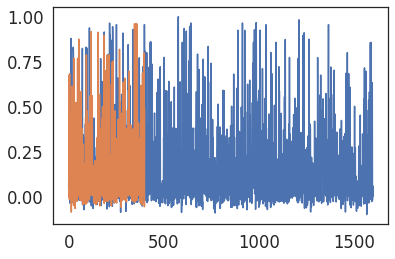

In [14]:
plt.plot(y_train[:,1])
plt.plot(y_test[:,1])

# Model initialization and parameters

In [15]:
# Instantiating model and optimizers
model = pdeX(nn_shared_features, nn_specific_features, 1)

In [16]:
optimizer = optim.Adam(learning_rate=learning_rate, beta1=0.99, beta2=0.99)
logger = Logger(path)
converged = Convergence(delta=deltaC)

In [17]:
sparsity_scheduler = mask_scheduler(delta=deltaSP)

In [18]:
# initializing
variables = model.init(key, X_train)
state, params = variables.pop('params')
y, updated_state = model.apply(variables, X_train, mutable=['coeffs_mask'])
optimizer = optimizer.create(params)
# compiling train step
update = create_update_state(loss_fn_pinn_multi2, model=model, x=X_train, y=y_train)
_ = update(optimizer, state)  # triggering compilation

# Training 

In [19]:
t_start = time()
counter = 0

for epoch in jnp.arange(max_epochs):

    # updating the model
    (optimizer, state), metrics, dt, theta, coeffs, coeffs_mask = update(optimizer, state)
    if epoch % 500 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}", end='\x1b[1K\r')
    
    if epoch % 25 == 0:   
        # computing losses on test set, masks are set individually
        loss_test, loss_test_exp_wise = mse_test(model, optimizer.target, state, X_test, y_test)
        loss_test_metric = {'loss_test':loss_test_exp_wise}
        
        ############ Logging the IRC ################################################
    
        metrics = {**metrics, **loss_test_metric}
        thetaNP = np.array(theta,dtype=np.float32).squeeze()
        dtNP = np.array(dt,dtype=np.float32).squeeze()

        # IRC
        # normalizing
        normed_theta = thetaNP/np.linalg.norm(thetaNP,axis=0,keepdims=True)
        normed_dt = dtNP/np.linalg.norm(dtNP,axis=0,keepdims=True)
        # with adaptive weights
        weights = (np.abs(Ridge(alpha=1e-10,fit_intercept=False).fit(normed_theta,normed_dt).coef_).ravel())**2
        normed_theta_w = normed_theta * weights[np.newaxis, :]

        # Once sparsity has been triggered
        if counter==1:
            ########################### for old DeepMod
            if method!='tLassoCV':
                [tau,piT,pSE,alphas, minLambdaSS, active_set,region] = extras
            
                # Probability of being selected
                pSEmax = np.array(pSE).max(axis=0)
                prob = {'prob_selec':pSEmax}   
                metrics = {**metrics, **prob}

                Point_of_View = np.where(active_set)[0].tolist()


            if method=='tLassoCV':
                Point_of_View = np.where(mask)[1].tolist()
            ########################### for old DeepMod

            # Diagnosing library design
            x1 = normed_theta_w[:,Point_of_View]
            x2 = normed_theta_w[:,np.setdiff1d(np.arange(0,normed_theta.shape[1]),np.array(Point_of_View))]

            metric_PoV = np.abs(np.linalg.inv(x1.T @ x1) @ x1.T @ x2)
            deltaPoV = np.linalg.norm(metric_PoV,1,axis=0).max()        
            lhs_PoV = {'PoV':np.array(deltaPoV)}        
            metrics = {**metrics, **lhs_PoV}
        
        logger.write(metrics, epoch)
        #############################################################################

        # optimizer best is based on group
        update_sparsity, optimizer = sparsity_scheduler(loss_test, epoch, optimizer)
        if update_sparsity:   
            ############################################################################################
            if counter == 0:
                np.save(path +'/theta_IN',theta)
                np.save(path +'/dt_IN',dt)
                counter = 1
                print('sparsity at ', epoch)

            # that component mask needs to be updated & new mask not yet computed
            new_mask,extras = get_mask_single(theta[0],dt[0],method=method)   
            new_mask = new_mask.reshape(1,new_mask.shape[0],new_mask.shape[1])
            ############################################################################################

            # update the masks, the state
            mask = new_mask
            state = freeze({'coeffs_mask': {'maskC': jnp.array(mask)}})


        if converged(epoch, coeffs):
            print(f'Converged at epoch {epoch}')

            np.save(path +'/theta_FIN',theta)
            np.save(path +'/dt_FIN',dt)

            break

logger.close()
t_end = time()

############################################################################################
############################################################################################                    

sparsity at  3000.0.001104446011595428K


/home/neptune/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.46115e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Converged at epoch 8700.01048855818808K


In [20]:
print(t_end - t_start)

347.02062225341797


# Results

In [21]:
new_params = optimizer.target
new_variables = freeze({'params': new_params.unfreeze(), **state.unfreeze()})

In [22]:
coeffs = model.apply(new_variables,X_train,mutable=['coeffs_mask'])[0][3]
xi = coeffs[:,:,0].T

In [23]:
scale_on_inputs = np.tile(np.array([1,x.max(),x.max()**2,x.max()**3,x.max()**4,x.max()**5]),6).reshape(-1,1)

coeffsS = xi*scale_on_inputs/t.max()
    
    
scaling_term_wise = []
scaling_all = []
for i in range(xi.shape[1]):
    
    scaling_term_wise.append([1,1/scale_from_outputs[i],   1/scale_from_outputs[i],   1/scale_from_outputs[i],    1/scale_from_outputs[i],   1/scale_from_outputs[i], 
                              1/scale_from_outputs[i],1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2, 1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**2,
                              1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3, 1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**3,
                              1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4, 1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**4,
                              1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5, 1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**5,
                              1/scale_from_outputs[i]**5,1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6, 1/scale_from_outputs[i]**6,1/scale_from_outputs[i]**6])
    
    scaling_all.append(np.repeat(np.array([scale_from_outputs[i]]),36)) 
    
scaling_term_wise = np.array(scaling_term_wise).T
scaling_all = np.array(scaling_all).T

## learned PDE coefficients

In [24]:
xi = np.array(coeffsS)*scaling_term_wise*scaling_all
xi

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-1.00505269],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-5.94351896],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

## recovered PDE terms

In [25]:
non_zero_terms = np.where(np.abs(xi)>0)[0]

In [26]:
np.array(lib_labels)[non_zero_terms]

array(['$u_{xxx}$', '$uu_x$'], dtype='<U14')

In [27]:
def X_new(nx,nt):
    x1 = jnp.linspace(x.min(), x.max(), nx)
    t1 = jnp.linspace(t.min(), t.max(), nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/t.max()).reshape(-1, 1), (x_grid/x.max()).reshape(-1, 1)], axis=1)

    return Xnn

nx = 100
nt = 100
uu = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))[0]

## learned underlying field

Text(4.5, 0.5, 't')

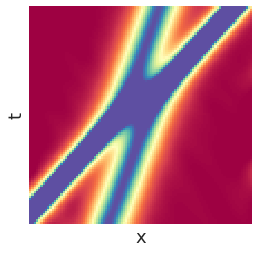

In [28]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

bx = sns.heatmap(uu[0][:,0].reshape(nt,nx)*scale_from_outputs[0],ax=ax,vmin=0,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t')

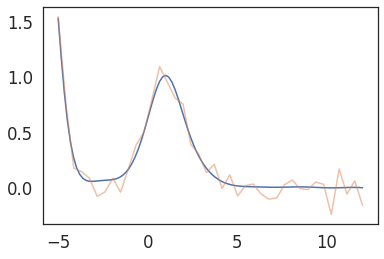

In [29]:
plt.plot(jnp.linspace(x.min(), x.max(), nx),(uu[0][:,0].reshape(nt,nx)[0,:])*scale_from_outputs[0])
plt.plot(x,u[:,0],alpha=0.5)

In [30]:
import pickle
np.save(path +'/scale_from_outputs',scale_from_outputs[0])
np.save(path +'/theta_FIN',theta)
np.save(path +'/dt_FIN',dt)
a_file = open(path + "/new_params.pkl", "wb")
pickle.dump(new_params.unfreeze(), a_file)
a_file.close()
a_file = open(path + "/state.pkl", "wb")
pickle.dump(state.unfreeze(), a_file)
a_file.close()